In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("allandclive/chicken-disease-1")

print("Path to dataset files:", path)

100%|██████████| 266M/266M [00:01<00:00, 222MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/allandclive/chicken-disease-1/versions/1


In [2]:
import os
import shutil

# Define the destination directory
dest_dir = "dataset"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Move all contents from the downloaded directory to the destination
for item in os.listdir(path):
    src_path = os.path.join(path, item)
    dest_path = os.path.join(dest_dir, item)
    shutil.move(src_path, dest_path)
    print(f"Moved: {item}")

print(f"All files have been moved to '{dest_dir}'")

Moved: train_data.csv
Moved: Train
All files have been moved to 'dataset'


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Step 1: Split data
def split_data(data_dir, csv_dir):
    df = pd.read_csv(csv_dir)
    df.columns = ['filepaths', 'labels']
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(data_dir, x))

    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, stratify=strat, random_state=123, shuffle=True)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, stratify=strat, random_state=123, shuffle=True)

    return train_df, valid_df, test_df

# Step 2: Create generators with improved augmentation
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    color = 'rgb'

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    valid_test_gen = ImageDataGenerator(rescale=1./255)

    train_data = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='sparse',
                                               color_mode=color, shuffle=True, batch_size=batch_size)

    valid_data = valid_test_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                                    target_size=img_size, class_mode='sparse',
                                                    color_mode=color, shuffle=False, batch_size=batch_size)

    test_data = valid_test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                   target_size=img_size, class_mode='sparse',
                                                   color_mode=color, shuffle=False, batch_size=batch_size)

    return train_data, valid_data, test_data

# Step 3: Load data
data_dir = '/content/dataset/Train'
csv_dir = '/content/dataset/train_data.csv'
train_df, valid_df, test_df = split_data(data_dir, csv_dir)
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

# Step 4: Define improved model
num_classes = len(train_gen.class_indices)

model = models.Sequential([
    layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()





Found 6453 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,684 (436.27 KB)

 Trainable params: 110,980 (433.52 KB)

 Non-trainable params: 704 (2.75 KB)

In [4]:
# Step 5: Define callbacks
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Step 6: Train the model
history = model.fit(train_gen, validation_data=valid_gen, epochs=30)
                    #callbacks=[early_stopping, lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 96s 420ms/step - accuracy: 0.6519 - loss: 0.9704 - val_accuracy: 0.3086 - val_loss: 2.1059
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 76s 377ms/step - accuracy: 0.7334 - loss: 0.7078 - val_accuracy: 0.5266 - val_loss: 1.6550
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 381ms/step - accuracy: 0.7774 - loss: 0.5918 - val_accuracy: 0.7026 - val_loss: 0.8522
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 385ms/step - accuracy: 0.8044 - loss: 0.5306 - val_accuracy: 0.6691 - val_loss: 1.1927
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 77s 379ms/step - accuracy: 0.8101 - loss: 0.5025 - val_accuracy: 0.7373 - val_loss: 0.8341
Epoch 6/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 76s 378ms/step - accuracy: 0.8197 - loss: 0.4745 - val_accuracy: 0.6914 - val_loss: 1.3142
Epoch 7/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 76s 378ms/step - accuracy: 0.8403 - loss: 0.4213 - val_accuracy: 0.7175 - val_loss: 0.9514
Epoch 8/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.8516 - loss: 0

In [8]:
# Save the full model including architecture, optimizer, and weights
model.save('chicken_disease_model.h5')

# Optional: Save only the weights
#model.save_weights('chicken_disease_weights.h5')

print("Model aved successfully!")


Model aved successfully!


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step

Classification Report:
                     precision    recall  f1-score   support

       Coccidiosis       0.99      0.92      0.96       247
           Healthy       0.92      0.74      0.82       241
New Castle Disease       0.73      0.79      0.76        56
        Salmonella       0.77      0.95      0.86       263

          accuracy                           0.87       807
         macro avg       0.86      0.85      0.85       807
      weighted avg       0.88      0.87      0.87       807



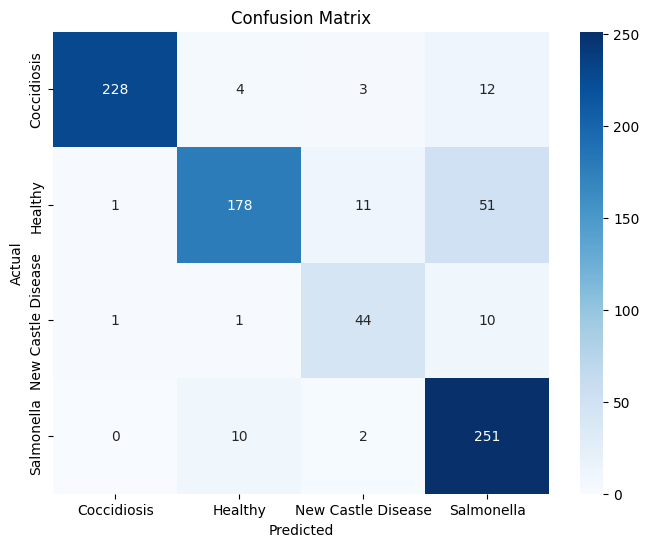

In [9]:
# Step 7: Evaluation
# Predict on test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Class names
class_names = list(test_gen.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


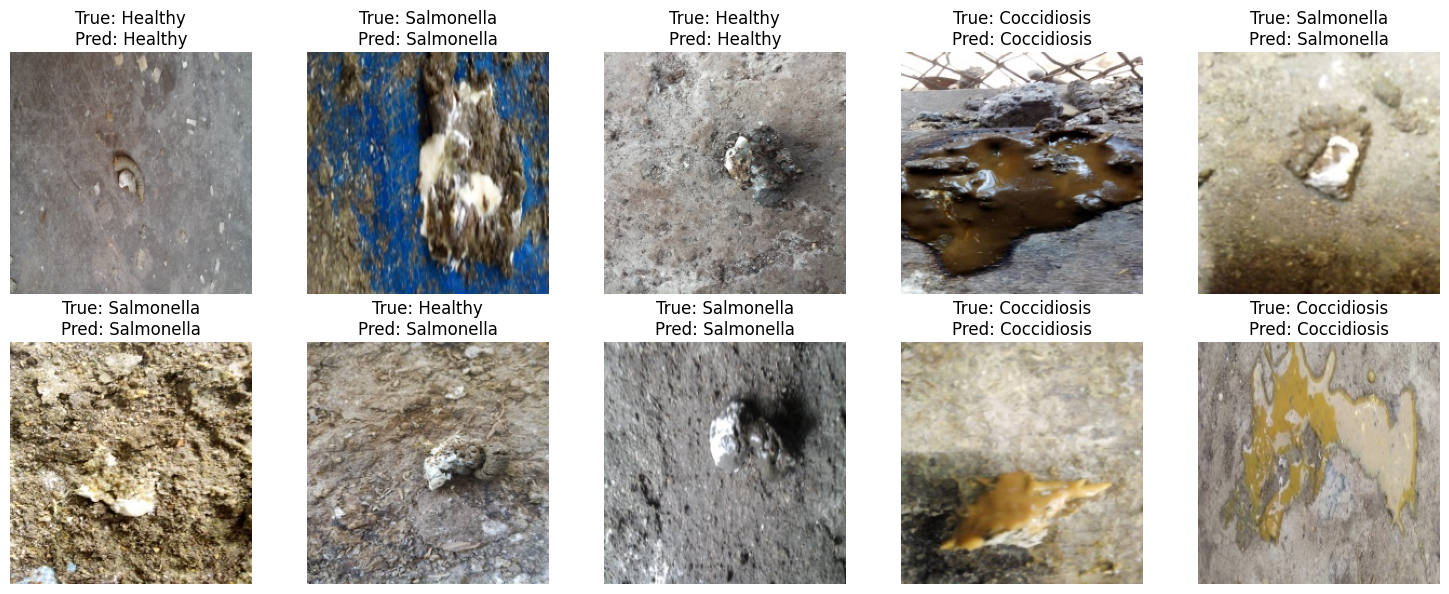

In [10]:
import random

plt.figure(figsize=(15, 6))
for i in range(10):
    idx = random.randint(0, len(test_gen.filenames) - 1)
    img_path = test_gen.filepaths[idx]
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize the image for prediction
    img_exp = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_exp)
    pred_class = class_names[np.argmax(pred)]
    true_class = class_names[y_true[idx]]

    # Scale the image back to [0, 255] for visualization
    img_to_display = (img_array * 255).astype("uint8")

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_to_display)
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()